### `Dynamic Hedging`

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

from scipy.stats import norm
import warnings

In [2]:
np.set_printoptions(precision = 3)

pd.set_option("precision", 3)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

In [3]:
warnings.filterwarnings("ignore")

Black-Scholes introduced the notion of dynamic delta hedging - by executing delta hedges instantaneously, we ensure that our portfolio is delta neutral, and consequently hedged the exposure of our call position using the underlying stock and the risk-free bond. 

The hedged portfolio is $V_t=\phi_tS_t+\psi_tB_t$, where 
\begin{equation*}
\phi_t=\Delta_t=\frac{\partial C}{\partial S}=\Phi\left(\frac{\log\frac{S}{K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

and

\begin{equation*}
\psi_tB_t=-Ke^{-rT}\Phi\left(\frac{\log\frac{S}{K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

Let us start by defining these stock and bond holding functions:

In [4]:
def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)

Next, define a Brownian motion which will be used to model the stock price process.

In [5]:
def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

Set the parameters of the Black Scholes Model as r = 5%, Initial stock price = 100, Strike price = 100 and a constant volatitily of 0.2. The time to maturity is 1 month and the stock price process is to be iterated 50000 times.

In [6]:
paths = 50000
steps = 1008 #In order to be divisible by our rebalancing periods of 21 and 84
maturity = 1.0/12 

T, W_T = simulate_Brownian_Motion(paths, steps, maturity)

r = 0.05
S0 = 100
K = 100
sigma = 0.2
dt = maturity / steps


Next, we shall simulate a single stock price process under the Black-Scholes dynamic, and follow the delta, stock and bond holdings over time until maturity. 

First we generate a single stock price process:

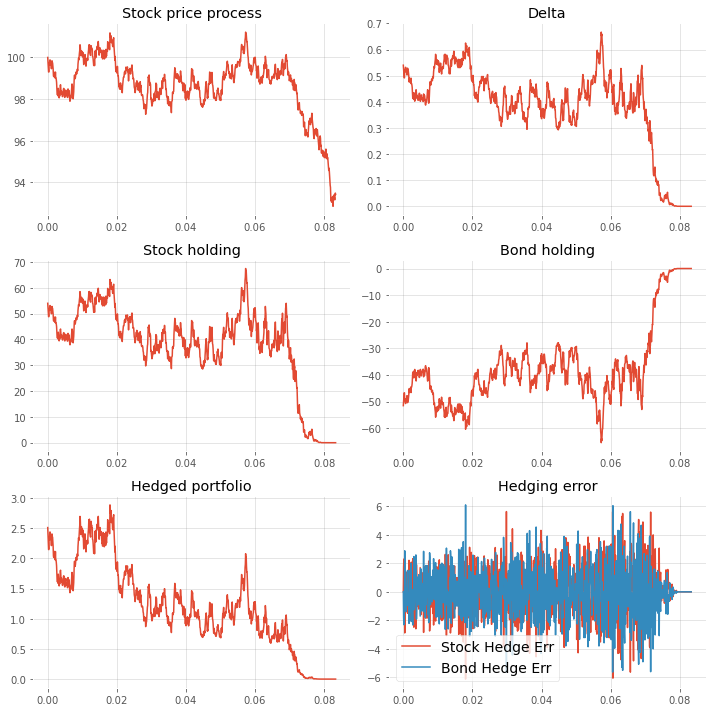

In [7]:
deltas = []
stockhedge_errors = []
bondhedge_errors = []
hedged_portfolios = []
stock_holdings = []
bond_holdings = []

blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])

for t, S_t in zip(T, blackscholespath):
    stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
    bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
    V_t = stock_pos + bond_pos
    stock_holdings.append(stock_pos)
    bond_holdings.append(bond_pos)
    hedged_portfolios.append(V_t)
    deltas.append(phi(S_t, K, r, sigma, maturity-t))
    if t == 0.0:
        stockhedge_errors.append(0)
        bondhedge_errors.append(0)
    else:
        stockhedge_errors.append(prev_phi*S_t - stock_pos)
        bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

    prev_phi = phi(S_t, K, r, sigma, maturity-t)
    prev_bond_pos = bond_pos

plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(321)
plt.plot(T, blackscholespath)
plt.title('Stock price process')
plt.subplot(322)
plt.plot(T, deltas)
plt.title('Delta')
plt.subplot(323)
plt.plot(T, stock_holdings)
plt.title('Stock holding')
plt.subplot(324)
plt.plot(T, bond_holdings)
plt.title('Bond holding')
plt.subplot(325)
plt.plot(T, hedged_portfolios)
plt.title('Hedged portfolio')
plt.subplot(326)
plt.plot(T, stockhedge_errors, label='Stock Hedge Err')
plt.plot(T, bondhedge_errors, label='Bond Hedge Err')
plt.legend()
plt.title('Hedging error')
plt.show()


The function `rebalance` obtains a new random stock price process and calculates the P&L of the hedged portfolio based on the number of rebalancing trades.

In [8]:
def rebalance(N):
    
    P_L = []
    
    for i in range(0, len(W_T)):

        deltas = []
        stockhedge_errors = []
        bondhedge_errors = []
        hedged_portfolios = []
        stock_holdings = []
        bond_holdings = []
                
        t_re = []
        s_re = []
            
        blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[i]) #Define a new stock price process 
    
        for x in np.linspace(0, 1008, N + 1, dtype="int"): #Obtain time and stock price at rebalancing positions
                    
            t_re.append(T[x])
            s_re.append(blackscholespath[x]) 
    
        for t, S_t in zip(np.array(t_re), np.array(s_re)):

            stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
            bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
            V_t = stock_pos + bond_pos
            stock_holdings.append(stock_pos)
            bond_holdings.append(bond_pos)
            hedged_portfolios.append(V_t)
            deltas.append(phi(S_t, K, r, sigma, maturity-t))
            if t == 0.0:
                stockhedge_errors.append(0)
                bondhedge_errors.append(0)
            else:
                stockhedge_errors.append(prev_phi*S_t - stock_pos)
                bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

            prev_phi = phi(S_t, K, r, sigma, maturity-t)
            prev_bond_pos = bond_pos

        P_L.append(np.array(stockhedge_errors).sum() + np.array(bondhedge_errors).sum())
    
    return(P_L)
    

In [9]:
P_21 = rebalance(21) # rebalance 21 times

In [10]:
P_84 = rebalance(84) # rebalance 84 times

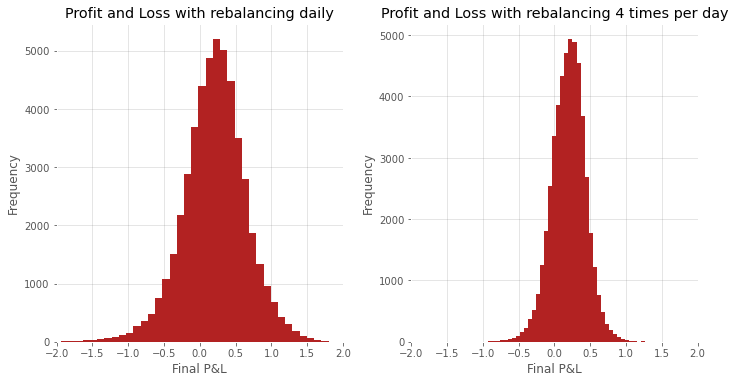

In [86]:
plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(221)
plt.hist(P_21, color="firebrick", bins = 50)
plt.title("Profit and Loss with rebalancing daily")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.xlim(-2,2)

plt.subplot(222)
plt.hist(P_84, color="firebrick", bins = 50)
plt.title("Profit and Loss with rebalancing 4 times per day")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.xlim(-2,2)

plt.show()

In [88]:
data = pd.DataFrame([[np.mean(P_21), np.std(P_21)], [np.mean(P_84), np.std(P_84)]],
                     index = [21,84],
                    )

data.columns = ["Mean P&L", "Std Deviation of P&L"]
data.index.name = "Number of Trades"


In [89]:
data

,Mean P&L,Std Deviation of P&L
Number of Trades,,
21,0.207,0.439
84,0.195,0.236


As observed from the results above, the average portfolio return differs from zero which seems counter intuitive. The above phenomenon can be explained by taking a deeper look into the stock price process.

The stock price under the Black-Scholes model is assumed to be following a Lognormal distribution. A lognormal distribution is positively skewed with its mode being lesser than its mean. From this we can infer that an ATM call will have a slightly higher than 50% probability of finishing OTM. For our case, since we have shorted a call option and are trying to imperfectly replicate a hedge, we get a return distribution with a mean which is slightly positive and with a negative skew. Rebalancing our portfolio fewer times leads to a mean return which is more shifted to the right and more negatively skewed.

However, the deviation from the desired mean return of zero is minimal. In addition, the standard deviation of returns is negligible too. To conclude, the Black Scholes framework for replicating an option payoff is indeed a robust model and relaxing the assumption of continuous rebalancing is valid for practical purposes.

`END`